In [7]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import scipy.stats as st
import contextlib
import arch
import pandas as pd
from scipy.stats import t, kstest


In [8]:
alpha95 = 0.95
alpha99 = 0.99
alphas = [alpha95, alpha99]

In [9]:
eu = pd.read_csv('data//CHFEUR.csv')
eu_przyr = pd.Series(eu["Open"].diff()/eu["Open"]).dropna()

eu['Returns'] = eu['Open'].pct_change().dropna() * 100
returns = eu['Returns'].dropna()


# ZADANIE 1

METODA PARAMETRYCZNA

In [10]:
params = t.fit(returns)

df, loc, scale = params

print(params)

df, loc, scale = params

x = np.linspace(returns.min(), returns.max(), 100)
pdf_fitted = t.pdf(x, df, loc, scale)
ks_stat, ks_p_value = kstest(returns, 't', args=(df, loc, scale))
print(f"KS Test Statistic: {ks_stat}, p-value: {ks_p_value}")


(5.091876111109471, 0.013314907723502066, 0.24668280380109076)
KS Test Statistic: 0.02044868765923069, p-value: 0.6385204181916084


In [11]:
(df, mean, scale) = params

def calculate_parametric_VaR(params, alpha95, alpha99):
    df, mean, scale = params
    VaR_95_t = mean + t.ppf(1 - alpha95, df) * scale
    VaR_99_t = mean + t.ppf(1 - alpha99, df) * scale
    return VaR_95_t, VaR_99_t

VaR_95_t ,VaR_99_t = calculate_parametric_VaR(params, alpha95, alpha99)

print(f'VaR_95% dla metody parametrycznej: {VaR_95_t:.4f}')
print(f'VaR_99% dla metody parametrycznej: {VaR_99_t:.4f}')

VaR_95% dla metody parametrycznej: -0.4818
VaR_99% dla metody parametrycznej: -0.8105


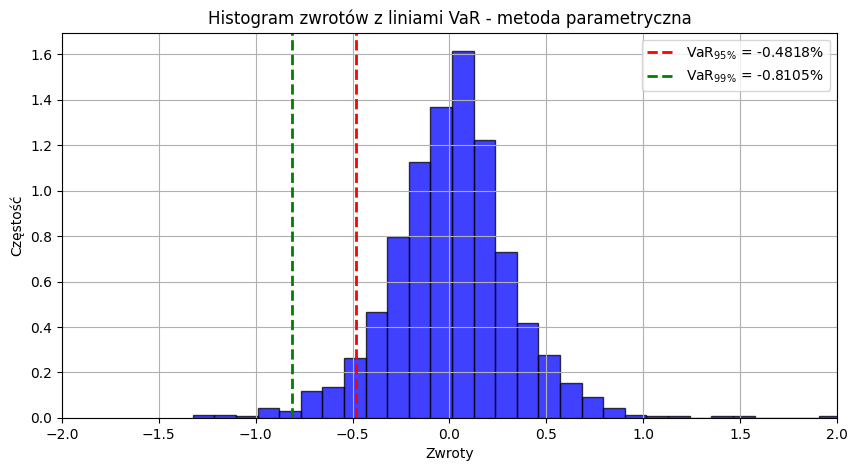

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(returns, bins=30, density=True, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=VaR_95_t, color='red', linestyle='dashed', linewidth=2, label=f'VaR$_{{95\%}}$ = {VaR_95_t:.4f}%')
plt.axvline(x=VaR_99_t, color='green', linestyle='dashed', linewidth=2,label=f'VaR$_{{99\%}}$ = {VaR_99_t:.4f}%')
plt.title('Histogram zwrotów z liniami VaR - metoda parametryczna')
plt.grid()
plt.xlabel('Zwroty')
plt.ylabel('Częstość')
plt.legend()
plt.xlim(-2, 2)
plt.show()


METODA HISTORYCZNA ZWYKŁA

In [13]:

def calculate_historical_VaR(returns, alpha95, alpha99):
    VaR_95_historical = returns.quantile(1 - alpha95)
    VaR_99_historical = returns.quantile(1 - alpha99)
    return VaR_95_historical, VaR_99_historical

VaR_95_historical, VaR_99_historical = calculate_historical_VaR(returns, alpha95, alpha99)
print(f'VaR_95% dla metody historycznej: {VaR_95_historical:.4f}')
print(f'VaR_99% dla metody historycznej: {VaR_99_historical:.4f}')

VaR_95% dla metody historycznej: -0.4925
VaR_99% dla metody historycznej: -0.8352


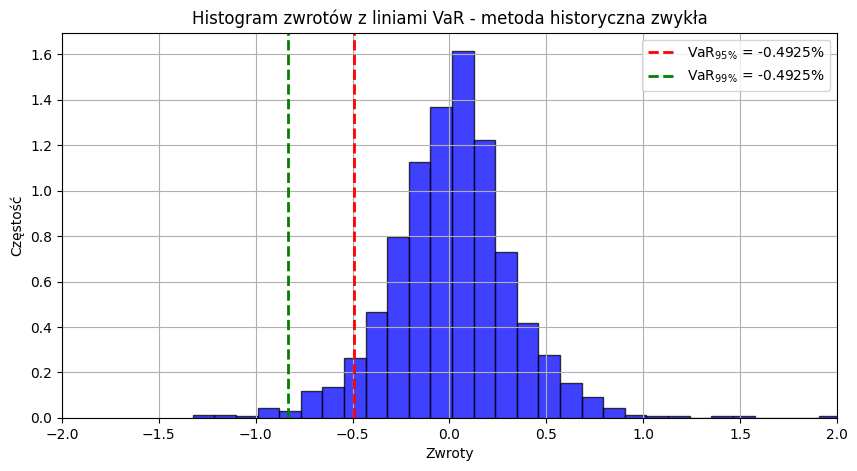

In [14]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.hist(returns, bins=30, density=True, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=VaR_95_historical, color='red', linestyle='dashed', linewidth=2,label=f'VaR$_{{95\%}}$ = {VaR_95_historical:.4f}%')
plt.axvline(x=VaR_99_historical, color='green', linestyle='dashed', linewidth=2,  label=f'VaR$_{{99\%}}$ = {VaR_95_historical:.4f}%')
plt.title('Histogram zwrotów z liniami VaR - metoda historyczna zwykła')
plt.xlabel('Zwroty')
plt.ylabel('Częstość')
plt.legend()
plt.xlim(-2, 2)
plt.show()


METODA HISTORYCZNA WAŻONA

In [15]:
import pandas as pd
import numpy as np

def calculate_weights_and_vars(returns, lambdas, alphas):
    all_results = {}
    for lambda_ in lambdas:
        t = len(returns)
        sum_geom = (1 - lambda_ ** t) / (1 - lambda_)
        w1 = 1 / sum_geom
        weights = np.array([lambda_ ** (i-1) * w1 for i in range(1, t+1)])

        data = pd.DataFrame({
            'Returns': returns,
            'Weights': weights
        })

        data_sorted = data.sort_values(by='Returns', ascending=True)
        data_sorted['Cumulative Probability'] = data_sorted['Weights'].cumsum()

        VaRs = {}
        for alpha in alphas:
            k_index = data_sorted[data_sorted['Cumulative Probability'] > 1-alpha].index[0]
            VaR = data_sorted.loc[k_index, 'Returns']
            VaRs[f"{int(alpha*100)}%"] = VaR

        all_results[lambda_] = VaRs

    return all_results


lambdas = [0.999, 0.97, 0.95]
alphas = [0.95, 0.99]  # Confidence levels

vars_historical_weighted = calculate_weights_and_vars(returns, lambdas, alphas)

for lambda_value, var_dict in vars_historical_weighted.items():
    for alpha, var in var_dict.items():
        print(f'VaR_{alpha}% dla metody historycznej ważonej oraz wartości lambda={lambda_value}: {var:.4f}')

VaR_95%% dla metody historycznej ważonej oraz wartości lambda=0.999: -0.4728
VaR_99%% dla metody historycznej ważonej oraz wartości lambda=0.999: -0.7875
VaR_95%% dla metody historycznej ważonej oraz wartości lambda=0.97: -0.3580
VaR_99%% dla metody historycznej ważonej oraz wartości lambda=0.97: -0.4177
VaR_95%% dla metody historycznej ważonej oraz wartości lambda=0.95: -0.4060
VaR_99%% dla metody historycznej ważonej oraz wartości lambda=0.95: -0.4060


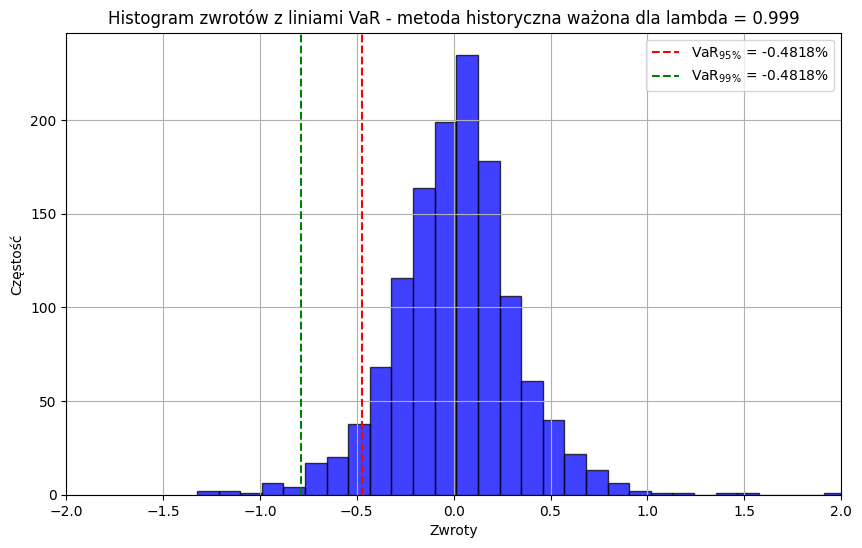

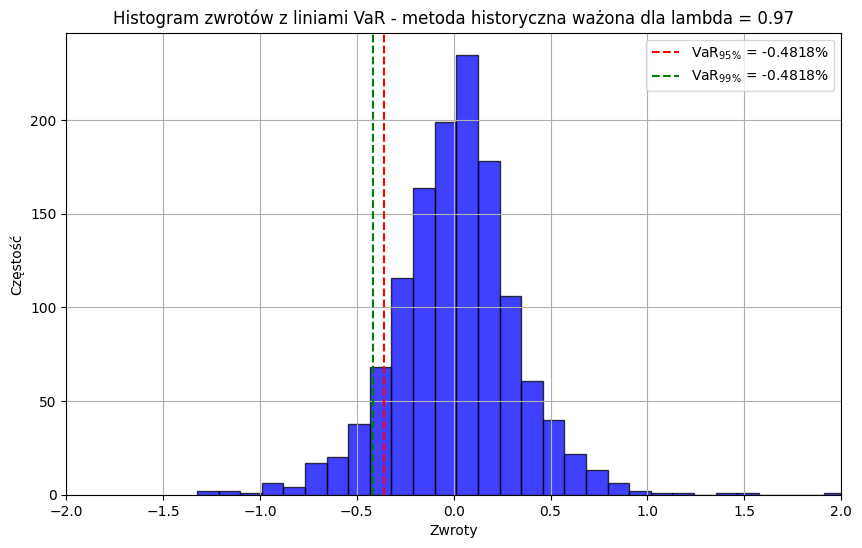

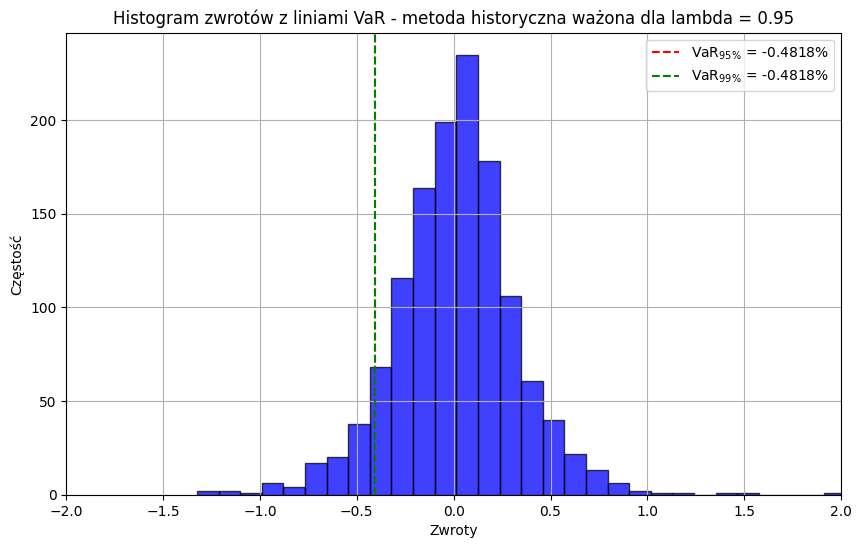

In [16]:
def plot_histogram_with_var_lines(returns, resulting_vars, lambdas, alphas):
    for lambda_, vars in resulting_vars.items():
        plt.figure(figsize=(10, 6))
        plt.hist(returns, bins=30, alpha=0.75, color='blue', edgecolor='black')
        colors = ['red', 'green']
        for i, alpha in enumerate(alphas):
            var_value = vars[f"{int(alpha*100)}%"]
            plt.axvline(x=var_value,label=f'VaR$_{{{int(alpha*100)}\%}}$ = {VaR_95_t:.4f}%', linestyle='--', color=colors[i])
        plt.title(f'Histogram zwrotów z liniami VaR - metoda historyczna ważona dla lambda = {lambda_}')
        plt.xlabel('Zwroty')
        plt.ylabel('Częstość')
        plt.legend()
        plt.xlim(-2, 2)
        plt.grid(True)
        plt.show()

plot_histogram_with_var_lines(returns, vars_historical_weighted, lambdas, alphas)

GARCH

In [17]:
import arch


def garch_VaR(data, alpha):
    model = arch.arch_model(data, vol='GARCH', p=1, q=1)
    res = model.fit(disp="off")

    forecast = res.forecast()

    sigma = np.sqrt(forecast.variance.values[-1])
    mean = forecast.mean.values[-1]

    filtred_losses = (data - res.params["mu"]) / res.conditional_volatility
    q = filtred_losses.quantile([alpha])
    if isinstance(q, pd.Series):
        q = q.iloc[0]

    var = mean + sigma * q

    return var
var_garch_95 = garch_VaR(returns, 1-alpha95)
var_garch_99 = garch_VaR(returns, 1-alpha99)


print(f'VaR_95% dla metody filtrowania szeregiem GARCH: {var_garch_95[0]:.4f}')

print(f'VaR_99% dla metody filtrowania szeregiem GARCH: {var_garch_99[0]:.4f}')

VaR_95% dla metody filtrowania szeregiem GARCH: -0.5071
VaR_99% dla metody filtrowania szeregiem GARCH: -0.7986


c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.p

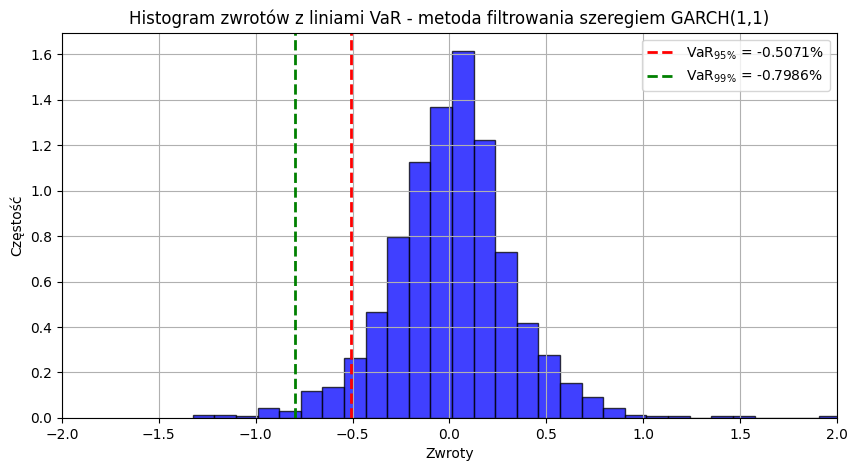

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(returns, bins=30, density=True, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(x=var_garch_95, color='red', linestyle='dashed', linewidth=2, label=f'VaR$_{{95\%}}$ = {var_garch_95[0]:.4f}%')
plt.axvline(x=var_garch_99, color='green', linestyle='dashed', linewidth=2,  label=f'VaR$_{{99\%}}$ = {var_garch_99[0]:.4f}%')
plt.title('Histogram zwrotów z liniami VaR - metoda filtrowania szeregiem GARCH(1,1)')
plt.xlabel('Zwroty')
plt.ylabel('Częstość')
plt.legend()
plt.xlim(-2, 2)
plt.grid()
plt.show()

Monte Carlo

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import t

def calculate_var(num_simulations=10000):
    simulated_returns = t.rvs(df, loc=loc, scale=scale, size=num_simulations)

    # Calculate VaR
    VaR_95 = np.percentile(simulated_returns, 5)  # 5th percentile for VaR at 95% confidence
    VaR_99 = np.percentile(simulated_returns, 1)  # 1st percentile for VaR at 99% confidence

    return VaR_95, VaR_99

var_95_monte_carlo, var_99_monte_carlo = calculate_var(num_simulations=10000)

print(f'VaR_95% dla metody MONTE CARLO: {var_95_monte_carlo:.4f}')
print(f'VaR_99% dla metody MONTE CARLO: {var_99_monte_carlo:.4f}')


VaR_95% dla metody MONTE CARLO: -0.4892
VaR_99% dla metody MONTE CARLO: -0.8228


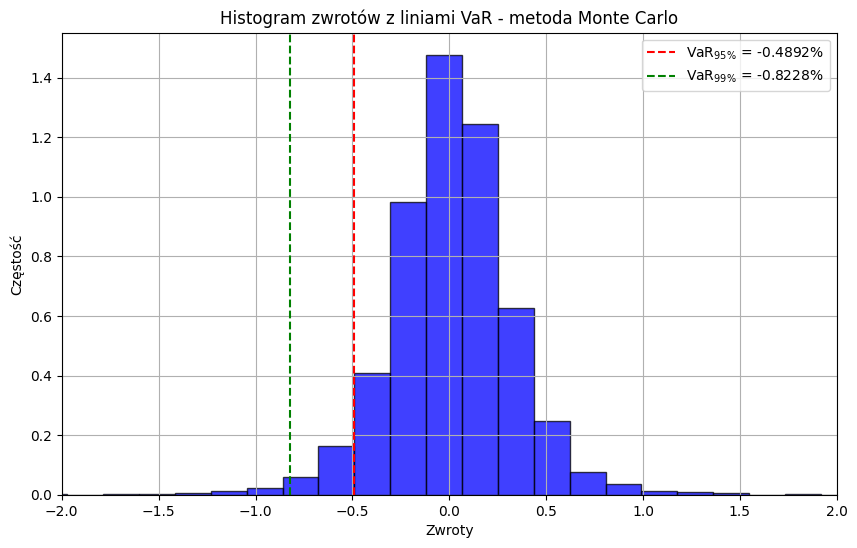

In [20]:

def plot_var(simulated_returns, VaR_95, VaR_99):
    plt.figure(figsize=(10, 6))
    plt.hist(simulated_returns, bins=30, density=True, alpha=0.75, color='blue', edgecolor='black')
    plt.axvline(x=VaR_95, color='red', linestyle='--', label=f'VaR$_{{95\%}}$ = {var_95_monte_carlo:.4f}%')
    plt.axvline(x=VaR_99, color='green', linestyle='--', label=f'VaR$_{{99\%}}$ = {var_99_monte_carlo:.4f}%')
    plt.title('Histogram zwrotów z liniami VaR - metoda Monte Carlo')
    plt.xlabel('Zwroty')
    plt.ylabel('Częstość')
    plt.grid()
    plt.xlim(-2, 2)
    plt.legend()
    plt.show()
simulated_returns = t.rvs(params[0], loc=params[1], scale=params[2], size=10000)
plot_var(simulated_returns, var_95_monte_carlo, var_99_monte_carlo)


porownanie

In [ ]:

def format_var(value):
    if isinstance(value, np.ndarray) and value.size == 1:
        value = value.item()
    elif isinstance(value, (list, tuple)) and len(value) == 1:
        value = value[0]
    return f"{value:.4f}"

results = pd.DataFrame({
    'METODA': ['Parametryczna', 'Historyczna', 'GARCH', 'Monte Carlo'] + [f'Hist. ważona dla λ={l}' for l in lambdas],
    'VaR 95%': [format_var(VaR_95_t), format_var(VaR_95_historical), format_var(var_garch_95), format_var(var_95_monte_carlo)] + [format_var(vars_historical_weighted[l]['95%']) for l in lambdas],
    'VaR 99%': [format_var(VaR_99_t), format_var(VaR_99_historical), format_var(var_garch_99), format_var(var_99_monte_carlo)] + [format_var(vars_historical_weighted[l]['99%']) for l in lambdas]
})
results

,METODA,VaR 95%,VaR 99%
0,Parametryczna,-0.4818,-0.8105
1,Historyczna,-0.4925,-0.8352
2,GARCH,-0.5071,-0.7986
3,Monte Carlo,-0.4892,-0.8228
4,Hist. ważona dla λ=0.999,-0.4728,-0.7875
5,Hist. ważona dla λ=0.97,-0.3580,-0.4177
6,Hist. ważona dla λ=0.95,-0.4060,-0.4060


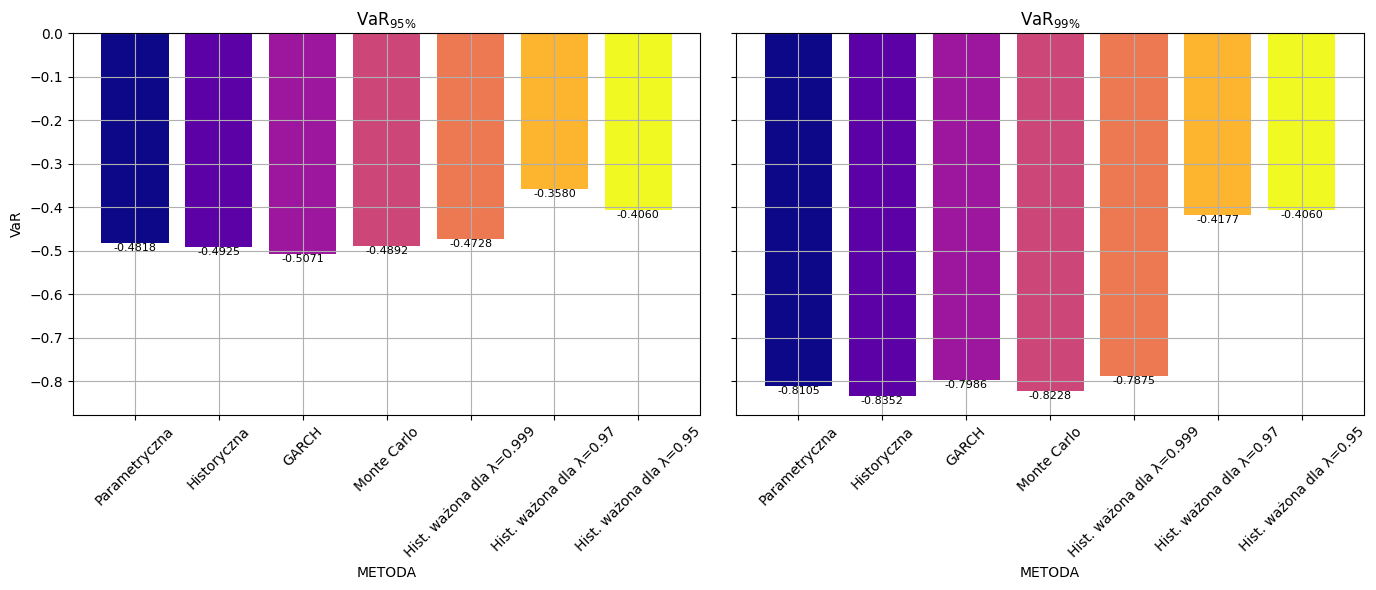

In [22]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

colors_95 = plt.cm.plasma(np.linspace(0, 1, len(results['METODA'])))
colors_99 = plt.cm.plasma(np.linspace(0, 1, len(results['METODA'])))

for idx, (method, var) in enumerate(zip(results['METODA'], results['VaR 95%'].astype(float))):
    axes[0].bar(method, var, color=colors_95[idx])
    axes[0].text(idx, var, f'{var:.4f}', ha='center', va='top', fontsize=8)

axes[0].set_title(r'VaR$_{95\%}$')
axes[0].set_xlabel('METODA')
axes[0].set_ylabel('VaR')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

for idx, (method, var) in enumerate(zip(results['METODA'], results['VaR 99%'].astype(float))):
    axes[1].bar(method, var, color=colors_99[idx])
    axes[1].text(idx, var, f'{var:.4f}', ha='center', va='top', fontsize=8)

axes[1].set_title(r'VaR$_{99\%}$')
axes[1].set_xlabel('METODA')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()


# ZADANIE 2


Backtesting metoda parametryczna

import scipy.stats as sp
import matplotlib.pyplot as plt

def backtesting_param(n, alpha):
    I = 0
    for i in range(len(X) - n - 1):
        I += sp.logistic.ppf(alpha, np.mean(X[i:i+n+1]), np.sqrt(3)/np.pi*np.std(X[i:i+n+1])) > X[i+n+1]
    return I / (len(X) - n)

alphas = np.linspace(0, 1, 100)
qs = backtesting_param(100, alphas)

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.plot(alphas, alphas)
plt.xlabel('α')
plt.ylabel('1 - prawd. przekroczenia')
plt.title('Parametryczny')
plt.show()


1      -0.357966
2      -0.140527
3      -0.217897
4      -0.406037
5       0.127904
          ...   
1301   -0.127896
1302   -0.492183
1303    0.238608
1304   -0.020401
1305    0.474019
Name: Returns, Length: 1305, dtype: float64


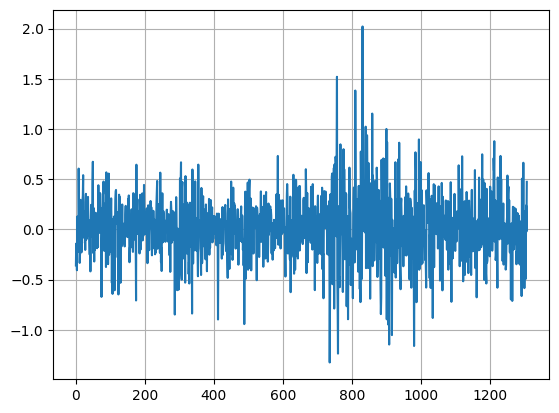

In [23]:
print(returns)
plt.plot(returns)
plt.grid()
plt.show()

KOD DO TESTU KUPCA

In [24]:
def kupiec(exceeds_vector, var_level):
    p, x, N = 1 - var_level, exceeds_vector.sum(), len(exceeds_vector)
    numerator = (1 - p) * (N - x) * p * x
    denominator = (1 - x / N) * (N - x) * (x / N) * x
    LR = -2 * np.log(numerator / denominator)
    return 1 - st.chi2.cdf(LR, df=1)

parametryczny

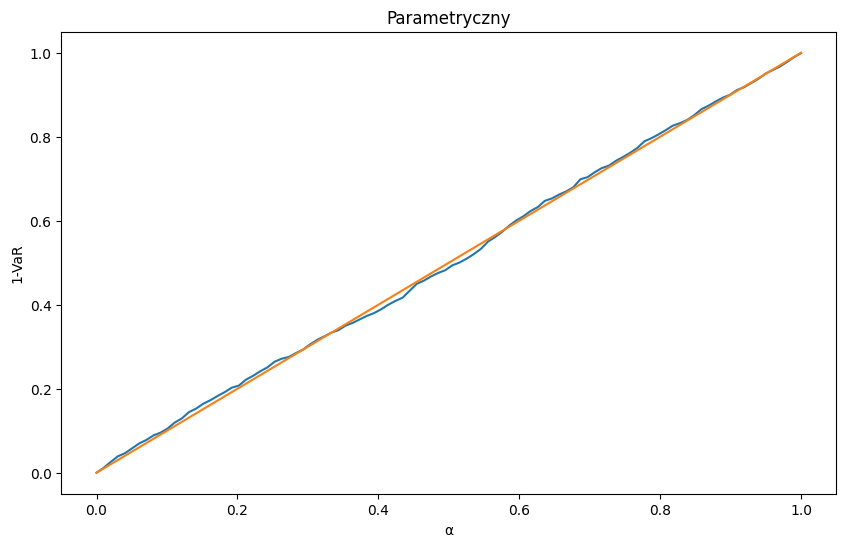

In [25]:
df_fitted, loc_fitted, scale_fitted = t.fit(returns)

def backtesting_param(X, n, alpha_level):
    I = 0
    for i in range(len(X) - n - 1):
        I += st.t.ppf(alpha_level, df_fitted,  loc_fitted, scale_fitted) > X[i+n+1]
    return I / (len(X) - n), I

# Nasze dane
X = returns

# Określenie poziomów alpha
alphas = np.linspace(0, 1, 100)

# Wywołanie funkcji backtesting_param
qs = backtesting_param(X, 100, alphas)[0]

# Wykres wyników
plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.plot(alphas, alphas)
plt.ylabel("1-VaR")
plt.xlabel('α')
plt.title('Parametryczny')
plt.show()


In [26]:
df_fitted, loc_fitted, scale_fitted = t.fit(returns)

def backtesting_param(X, n, alpha_level, var_level):
    I = np.zeros(len(X) - n)
    for i in range(len(X) - n):
        I[i] = st.t.ppf(alpha_level, df_fitted, loc_fitted, scale_fitted) > X[i+n]
    p_value = kupiec(I, var_level)
    return p_value, I

# Przykładowe dane testowe
alpha_level = 0.05  # Poziom istotności testu parametrycznego
var_level95 = 0.95  # Poziom VaR
var_level99 = 0.99  # Poziom VaR

# Wywołanie funkcji backtesting_param
p_value1, I1 = backtesting_param(returns, 100, alpha_level, var_level95)
p_value2, I2 = backtesting_param(returns, 100, alpha_level, var_level99)
print("P-wartość dla VaR95%:", p_value1)
print("P-wartość dla VaR99%:", p_value2)

P-wartość dla VaR95%: 0.6129774043480734
P-wartość dla VaR99%: 0.06550343176598106


Backtesting metoda ważona

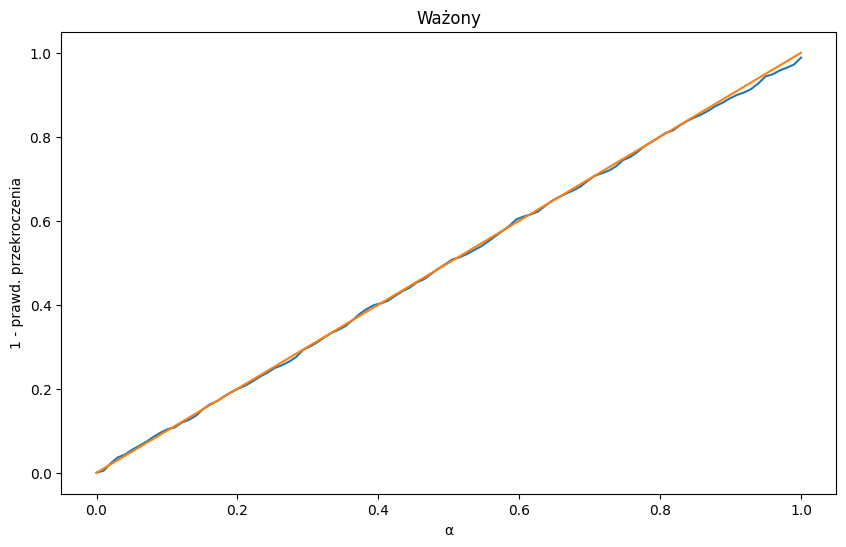

In [27]:
X = returns

def hist_weight_fun(lam,ps,x):
    n = len(x)
    lambda_s = [lam**i for i in range(1,n)]
    
    ws = np.zeros((n))
    ws[0] = 1/(1+sum(lambda_s))
    ws[1:] = [ws[0]*lam**i for i in range(1,n)]

    m = np.array([x,ws])
    mt = np.transpose(m)
    hist_weight = pd.DataFrame(mt,columns=['L','w'])
    hist_weight = hist_weight.sort_values(by=['L'])
    hist_weight = hist_weight.reset_index(drop=True)

    hist_weight['w_s'] = np.zeros(n)
    for i in range(0,n):
        hist_weight['w_s'][i] = sum(hist_weight['w'][:i+1])

    result = [float(hist_weight.iloc[(hist_weight['w_s']-p).abs().argsort()[:1]]['L']) for p in ps]
    return(result)

def backtesting_weight(n, alpha, lam):
    I = 0
    for i in range(len(X) - n - 1):
        I +=  hist_weight_fun(lam,alpha,X[i:i+n+1]) > X[i+n+1]
    return I / (len(X) - n), I

alphas = np.linspace(0, 1, 100)
qs = backtesting_weight(100, alphas, 0.99)[0]

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.plot(alphas, alphas)
plt.xlabel('α')
plt.ylabel('1 - prawd. przekroczenia')
plt.title('Ważony')
plt.show()

In [28]:
def backtesting_weight(X, n, alpha, lam, var_level):
    I = np.zeros(len(X) - n)
    for i in range(len(X) - n):
        I[i] = hist_weight_fun(lam, alpha, X[i:i+n+1]) > X[i+n]
    p_value = kupiec(I, var_level)
    return p_value, I

# Przykładowe dane testowe
alpha_level = 0.05  # Poziom istotności testu parametrycznego
var_level95 = 0.95  # Poziom VaR
var_level99 = 0.99  # Poziom VaR

# Wywołanie funkcji backtesting_param
p_value3, I3 = backtesting_weight(returns, 100, alpha_level, 0.99, var_level95)
p_value4, I4 = backtesting_weight(returns, 100, alpha_level, 0.99, var_level99)

TypeError: 'float' object is not iterable

In [ ]:
print("P-wartość dla VaR95%:", p_value3)
print("P-wartość dla VaR99%:", p_value4)

P-wartość dla VaR95%: 0.8159033541431502
P-wartość dla VaR99%: 0.07406310629409818


Backtesting metoda historyczna zwykła

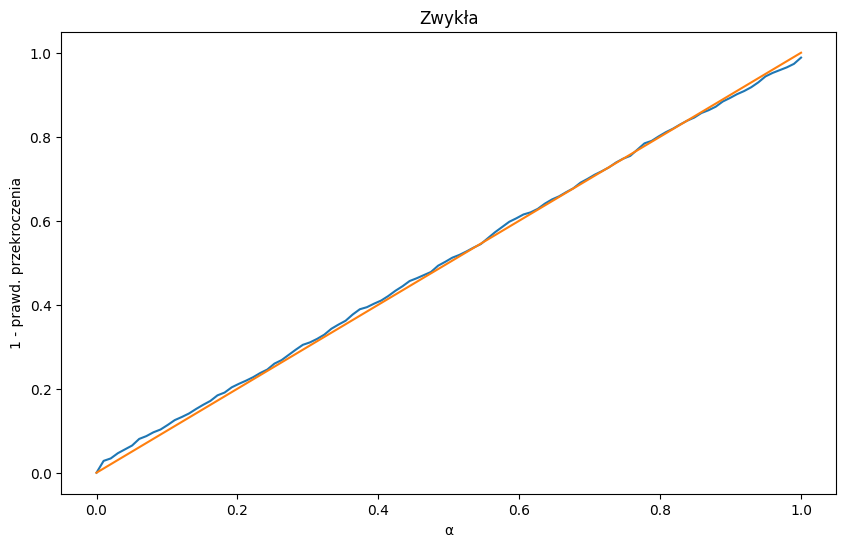

In [ ]:
def backtesting_emp(n, alpha):
    I = 0
    for i in range(len(X) - n - 1):
        I += np.quantile(X[i:i+n+1], alpha) > X[i+n+1]
    return I / (len(X) - n), I

alphas = np.linspace(0, 1, 100)
qs = backtesting_emp(100, alphas)[0]

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs)
plt.plot(alphas, alphas)
plt.xlabel('α')
plt.ylabel('1 - prawd. przekroczenia')
plt.title('Zwykła')
plt.show()

In [ ]:
def backtesting_emp(X, n, alpha, var_level):
    I = np.zeros(len(X) - n)
    for i in range(len(X) - n):
        if isinstance(alpha, list):
            for a in alpha:
                I[i] += np.quantile(X[i:i+n+1], a) > X[i+n]
        else:
            I[i] = np.quantile(X[i:i+n+1], alpha) > X[i+n]
    p_value = kupiec(I, var_level) if isinstance(var_level, list) else kupiec(I, var_level)
    return p_value, I

# Przykładowe dane testowe
alpha_level = 0.05  # Poziom istotności testu parametrycznego
var_level95 = 0.95  # Poziom VaR
var_level99 = 0.99  # Poziom VaR

# Wywołanie funkcji backtesting_param
p_value5, I5 = backtesting_emp(returns, 100, alpha_level, var_level95)
p_value6, I6 = backtesting_emp(returns, 100, alpha_level, var_level99)

print("P-wartość dla VaR95%:", p_value5)
print("P-wartość dla VaR99%:", p_value6)

P-wartość dla VaR95%: 0.6781347034214518
P-wartość dla VaR99%: 0.06891721455897293


Backtesting dla GARCH

In [ ]:
def back_garch_jutro(X, n, alpha, var_level):
    with contextlib.redirect_stdout(None):
        I = np.zeros(len(X) - n)
        for i in range(len(X) - n ):
            model = arch.arch_model(X[i:i+n+1], vol='GARCH', p=1, q=1, rescale=False)
            results = model.fit()
            L = results.std_resid
            I[i] += int(float(np.quantile(L, alpha) * np.sqrt(results.forecast().variance.iloc[-1])) < X[i+n+1])

        p_value = kupiec(I, var_level) if isinstance(var_level, list) else kupiec(I, var_level)

    return p_value, I

# Przykładowe dane testowe
alpha_level = 0.05  # Poziom istotności testu 
var_level95 = 0.95  # Poziom VaR
var_level99 = 0.99  # Poziom VaR

# Wywołanie funkcji backtesting_param
p_value7, I7 = back_garch_jutro(returns, 100, alpha_level, var_level95)
p_value8, I8 = back_garch_jutro(returns, 100, alpha_level, var_level99)

print("P-wartość dla VaR95%:", p_value7)
print("P-wartość dla VaR99%:", p_value8)

# P-wartość dla VaR95%: 1.0
# P-wartość dla VaR99%: 0.08898747828141884

c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

P-wartość dla VaR95%: 1.0
P-wartość dla VaR99%: 0.08898747828141884


c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

In [ ]:
def back_garch_30(X, n, alpha, var_level):
    with contextlib.redirect_stdout(None):
        I = np.zeros(len(X) - n)
        for i in range(len(X) - n ):
            model = arch.arch_model(X[i:i+n+1], vol='GARCH', p=1, q=1, rescale=False)
            results = model.fit()
            L = results.std_resid
            I[i] += (float(np.quantile(L, alpha) * np.sqrt(results.forecast(horizon=30).variance.iloc[-1,:][-1])) < X[i+n+1])
        
        p_value = kupiec(I, var_level) if isinstance(var_level, list) else kupiec(I, var_level)

    return p_value, I

# Przykładowe dane testowe
alpha_level = 0.05  # Poziom istotności testu 
var_level95 = 0.95  # Poziom VaR
var_level99 = 0.99  # Poziom VaR

# Wywołanie funkcji backtesting_param
p_value9, I9 = back_garch_30(returns, 100, alpha_level, var_level95)
p_value10, I10 = back_garch_30(returns, 100, alpha_level, var_level99)

print("P-wartość dla VaR95%:", p_value9)
print("P-wartość dla VaR99%:", p_value10)

# P-wartość dla VaR95%: 1.0 # troche chuowo ale stabilnie
# P-wartość dla VaR99%: 0.07693399698026415

c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

P-wartość dla VaR95%: 1.0
P-wartość dla VaR99%: 0.07693399698026415


c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After Septe

Backtesting dla Monte Carlo

In [ ]:
def monte_carlo_backtesting(returns, alpha_level, var_level, num_simulations=10000):
    # Symuluj zwroty
    simulated_returns = t.rvs(df_fitted, loc=loc_fitted, scale=scale_fitted, size=num_simulations)

    # Oblicz przekroczenia dla różnych wartości alfa
    alphas = np.linspace(0, 1, 100)  # Wartości alfa od 0 do 1 z krokiem 0.01
    exceedances = []

    for alpha in alphas:
        exceedances.append(np.sum(simulated_returns < np.percentile(simulated_returns, alpha * 100)))

    # Oblicz ilość przekroczeń
    num_simulations_array = np.full_like(alphas, num_simulations)
    quantiles = np.array(exceedances) / num_simulations_array

    p_value = kupiec(quantiles, var_level) if isinstance(var_level, list) else kupiec(quantiles, var_level)

    return p_value

# Przykładowe dane testowe
alpha_level = 0.05  # Poziom istotności testu parametrycznego
var_level95 = 0.95  # Poziom VaR
var_level99 = 0.99  # Poziom VaR

# Wywołanie funkcji backtesting_param
p_value7 = monte_carlo_backtesting(returns, alpha_level, var_level95, num_simulations=10000)
p_value8 = monte_carlo_backtesting(returns, alpha_level, var_level99, num_simulations=10000)

print("P-wartość dla VaR95%:", p_value7)
print("P-wartość dla VaR99%:", p_value8)

P-wartość dla VaR95%: 0.06838097690949829
P-wartość dla VaR99%: 0.01104630772323878
